small_1: 5
small_2: 8
small_3: 9
large_1: 12
large_2: 22
large_3: 24
large_4: 33
large_5: 35
large_6: 36
large_7: 38


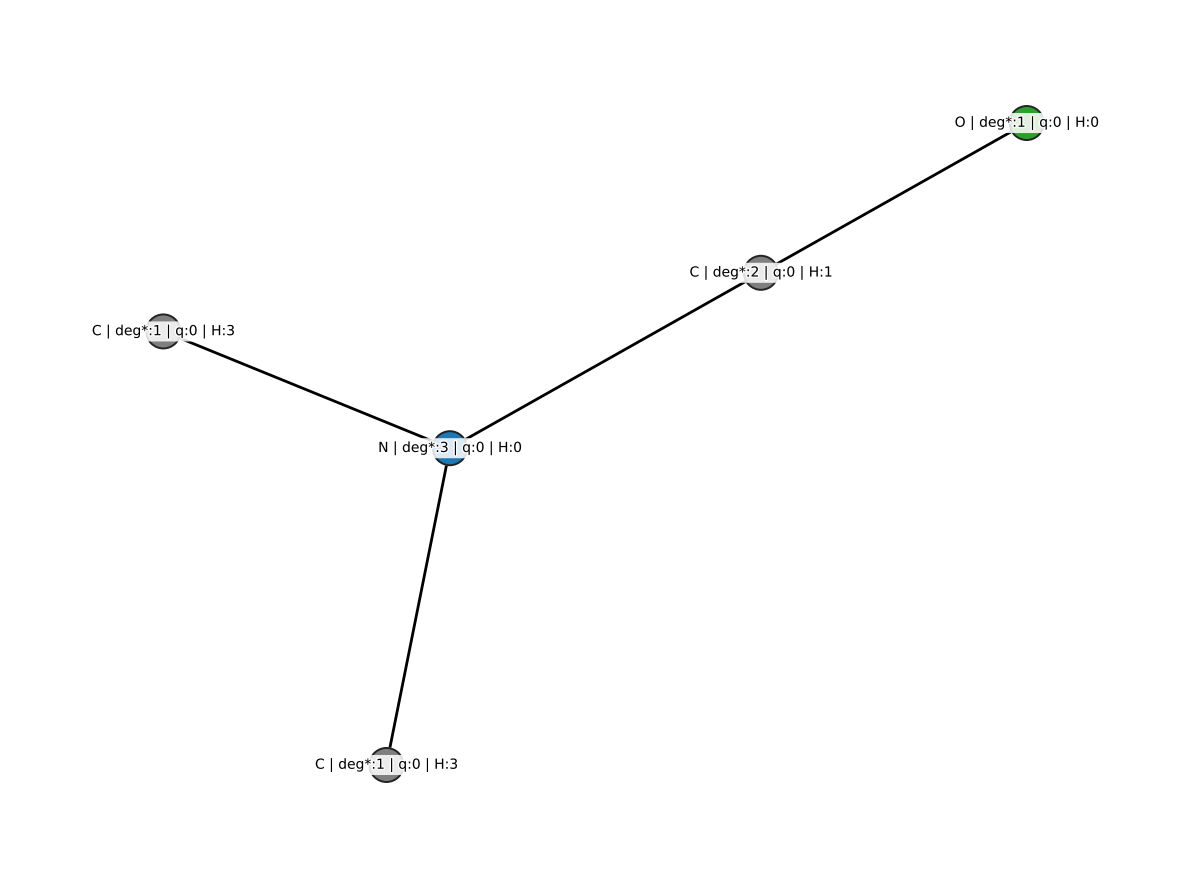

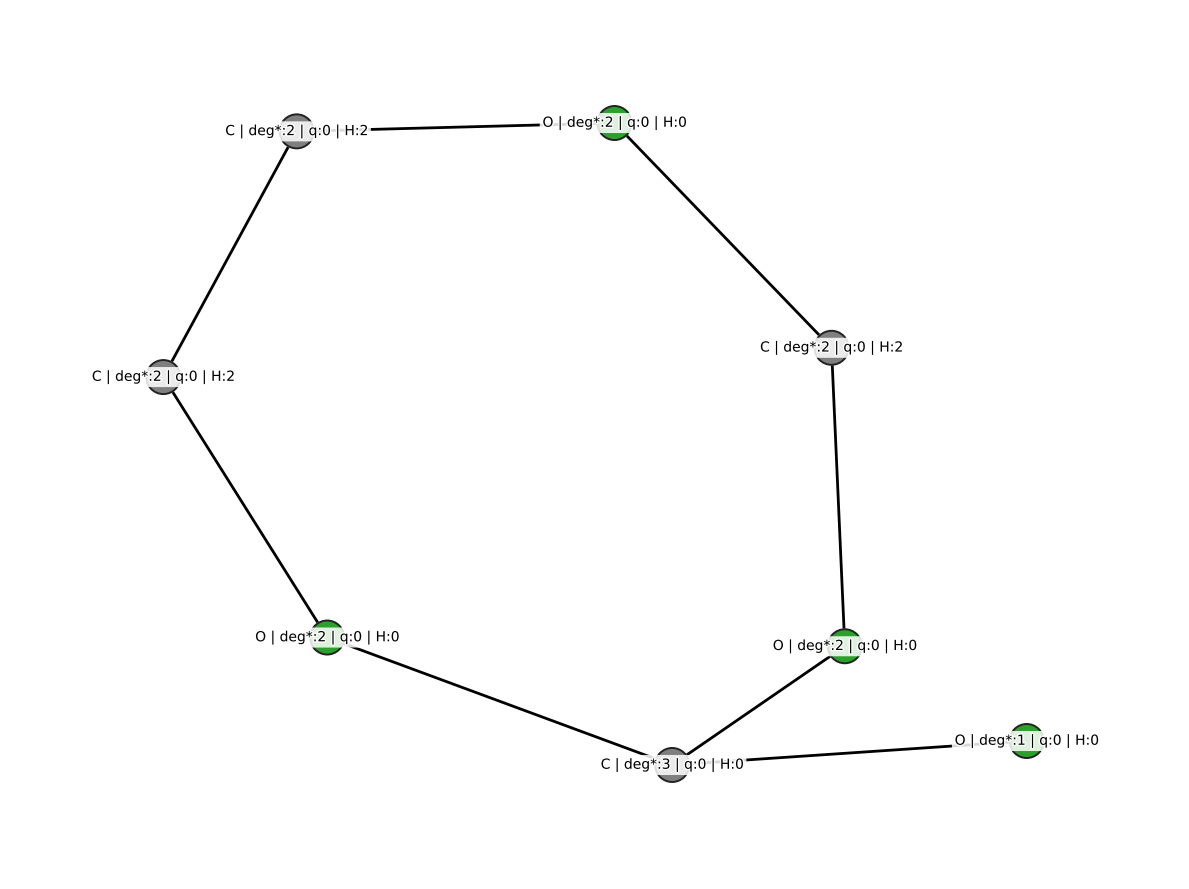

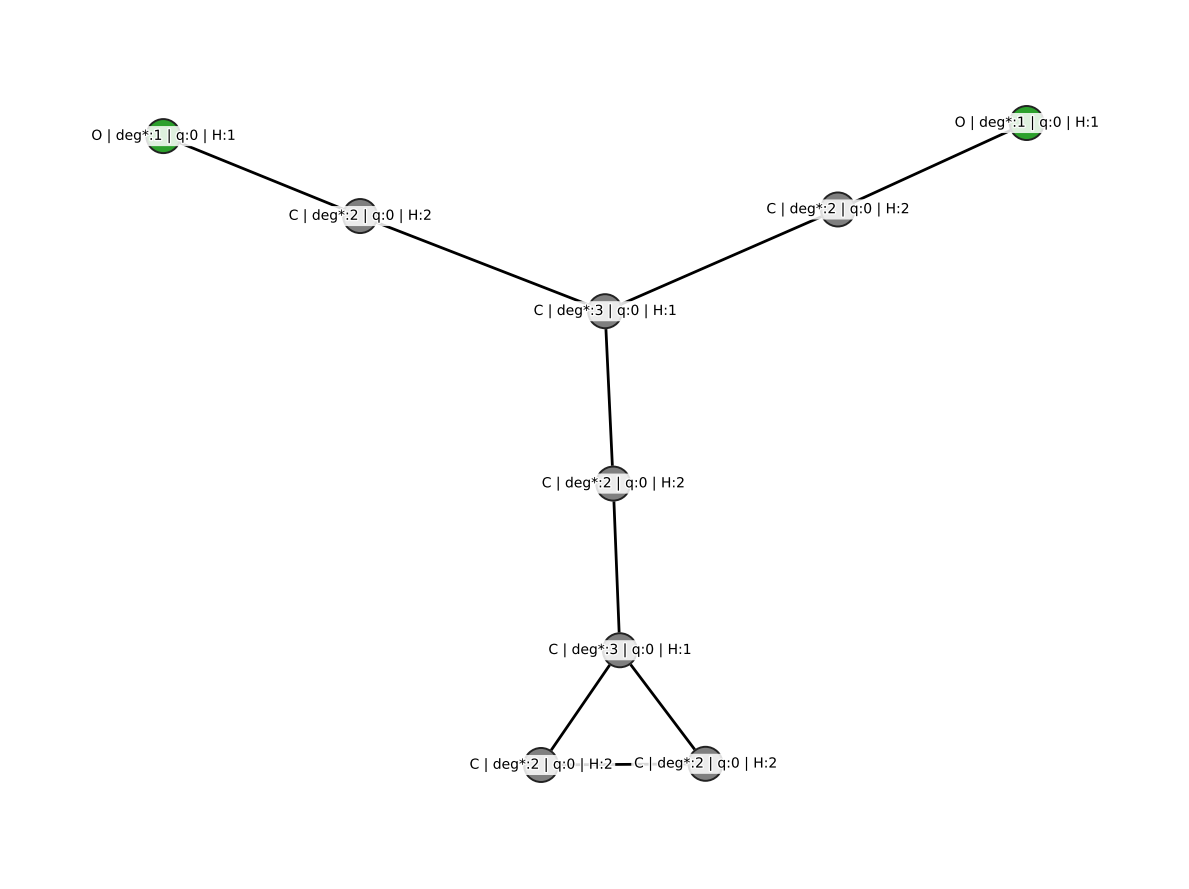

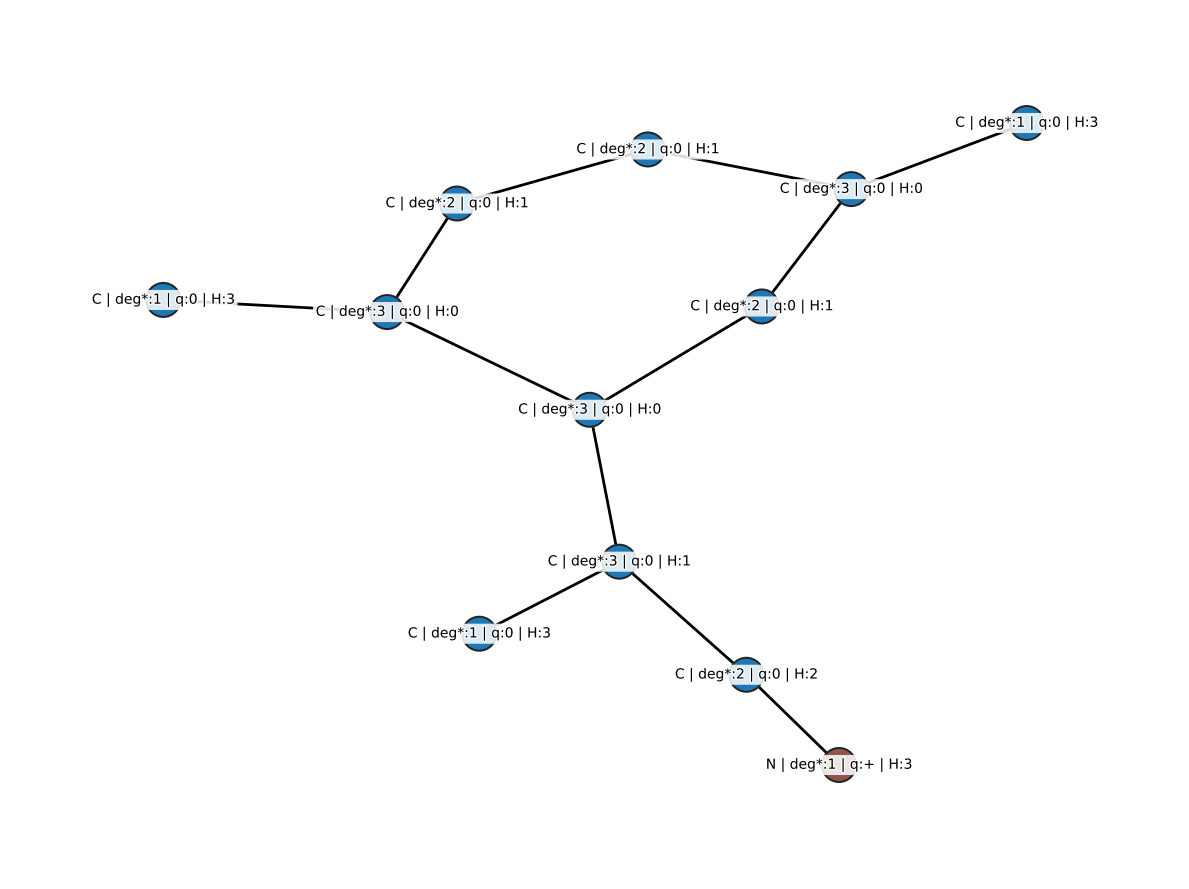

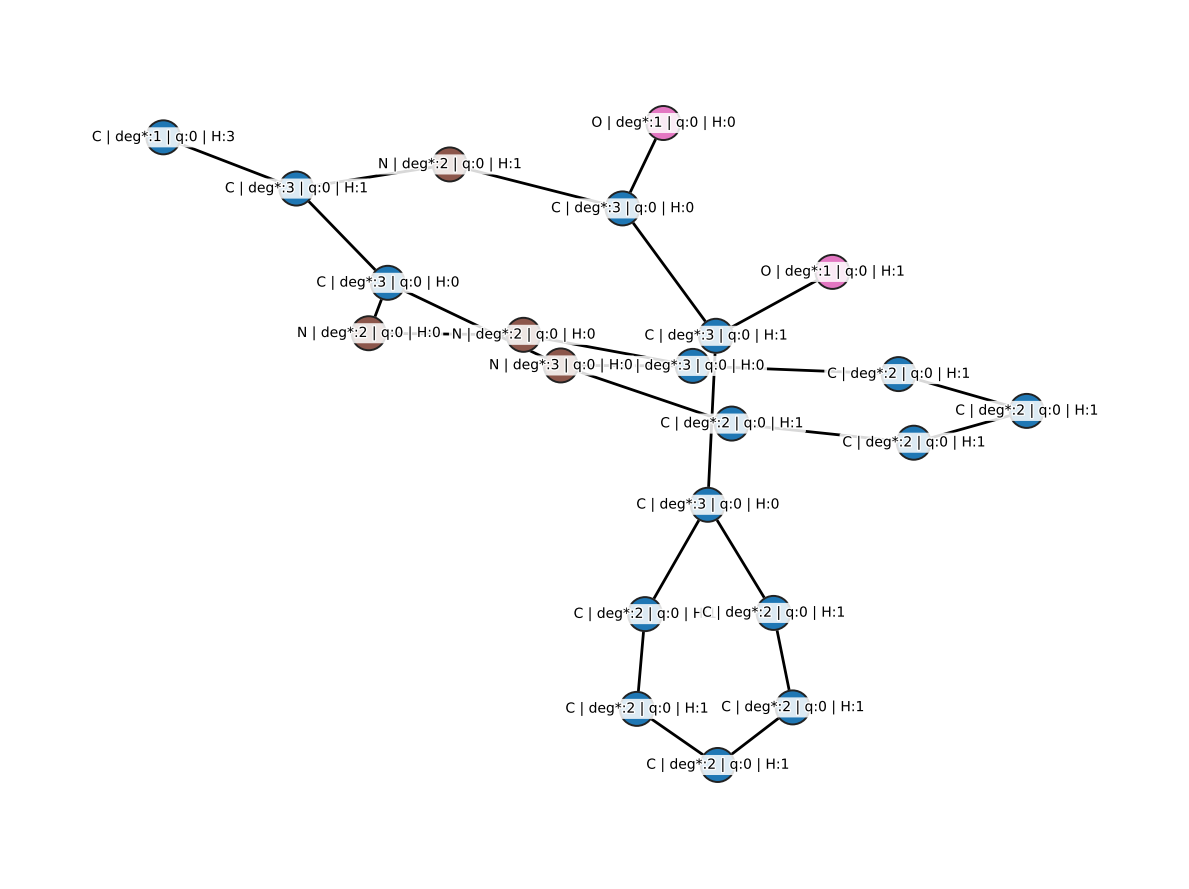

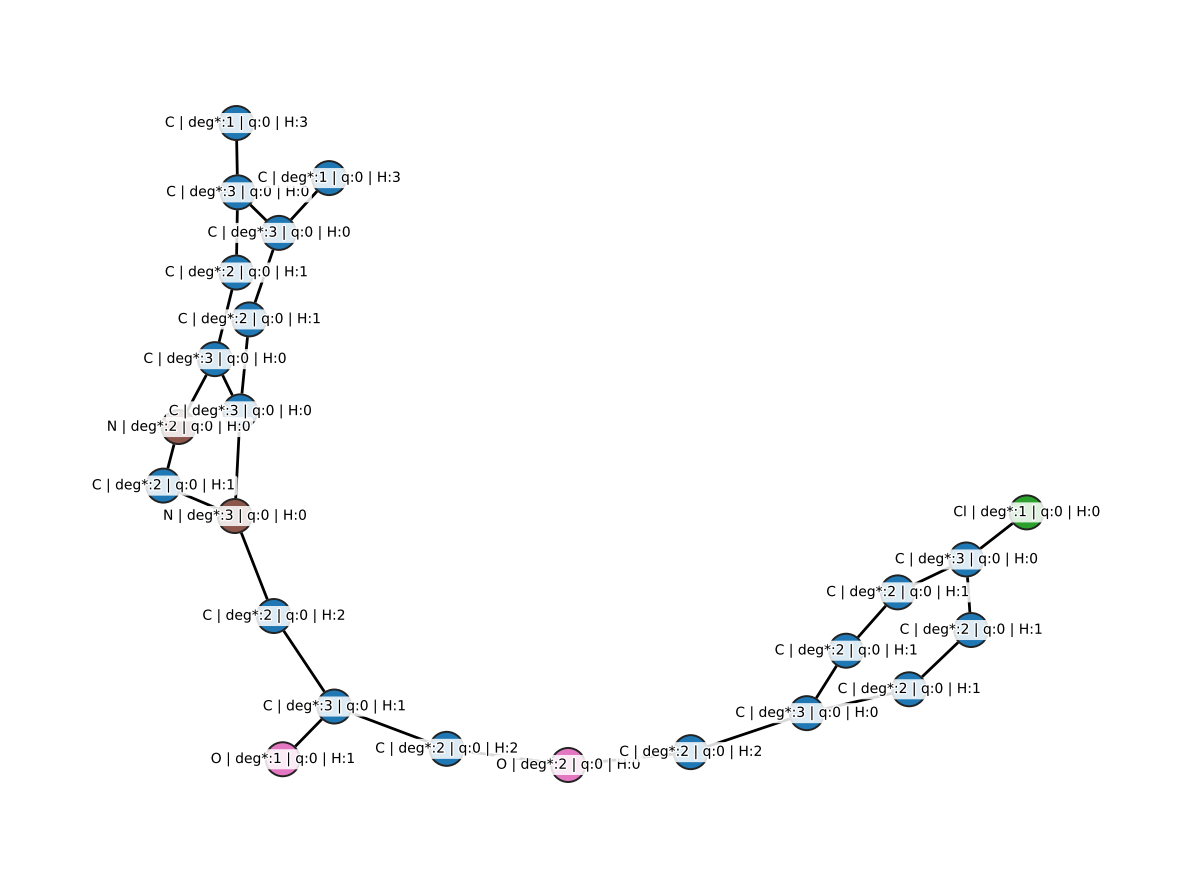

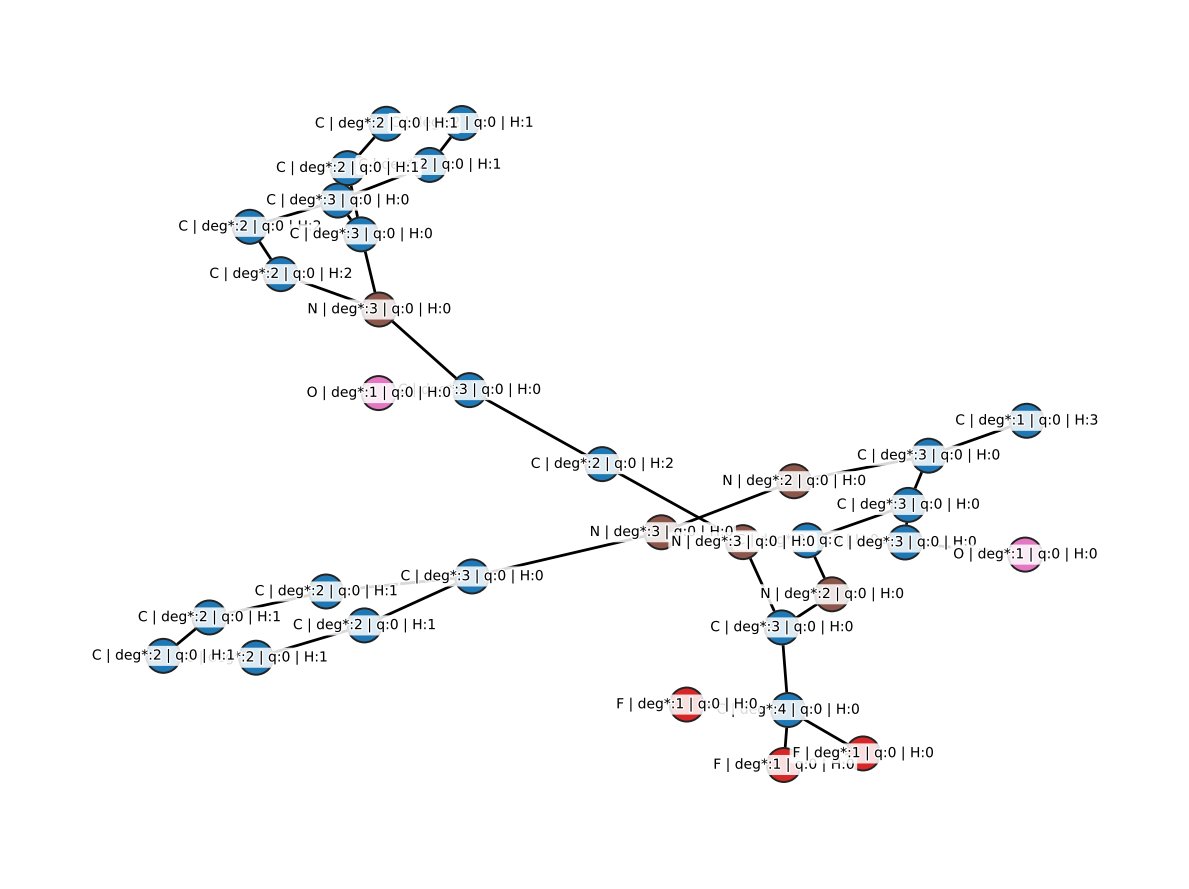

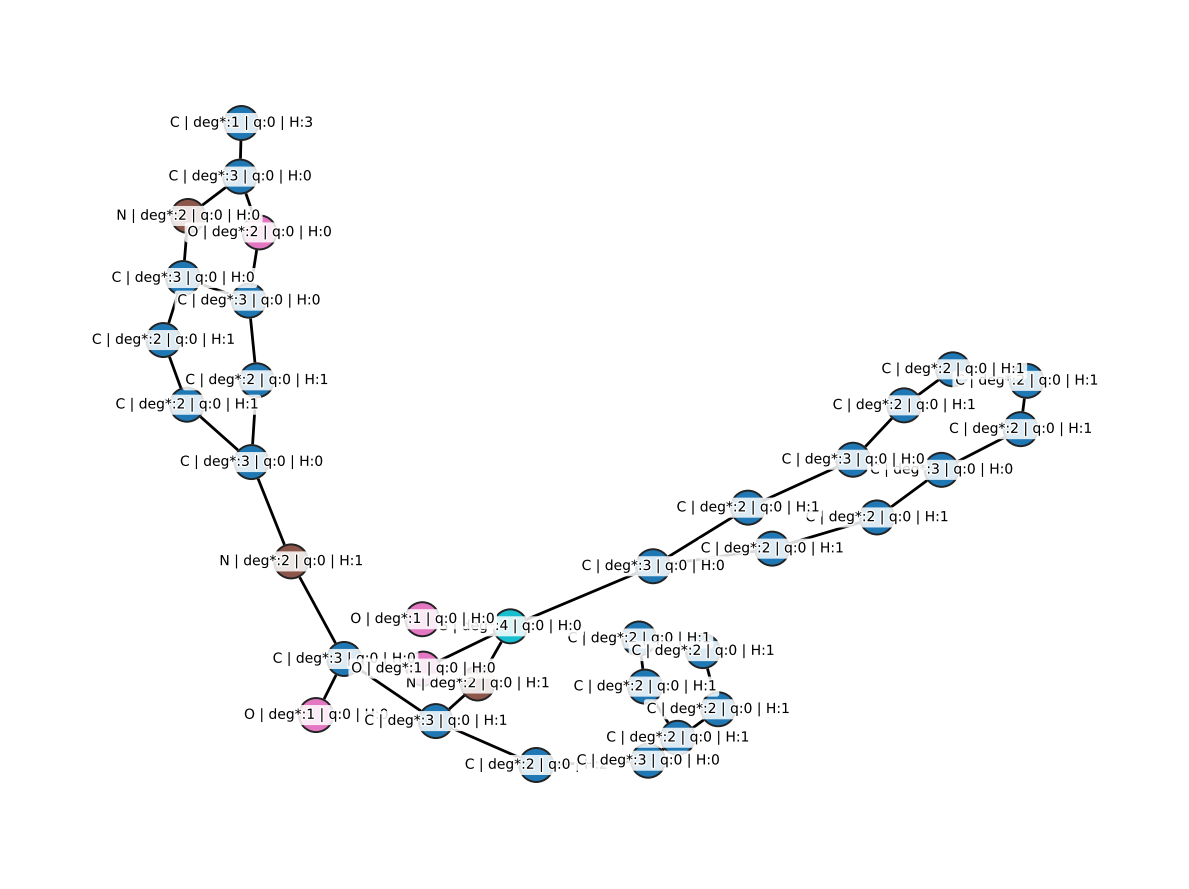

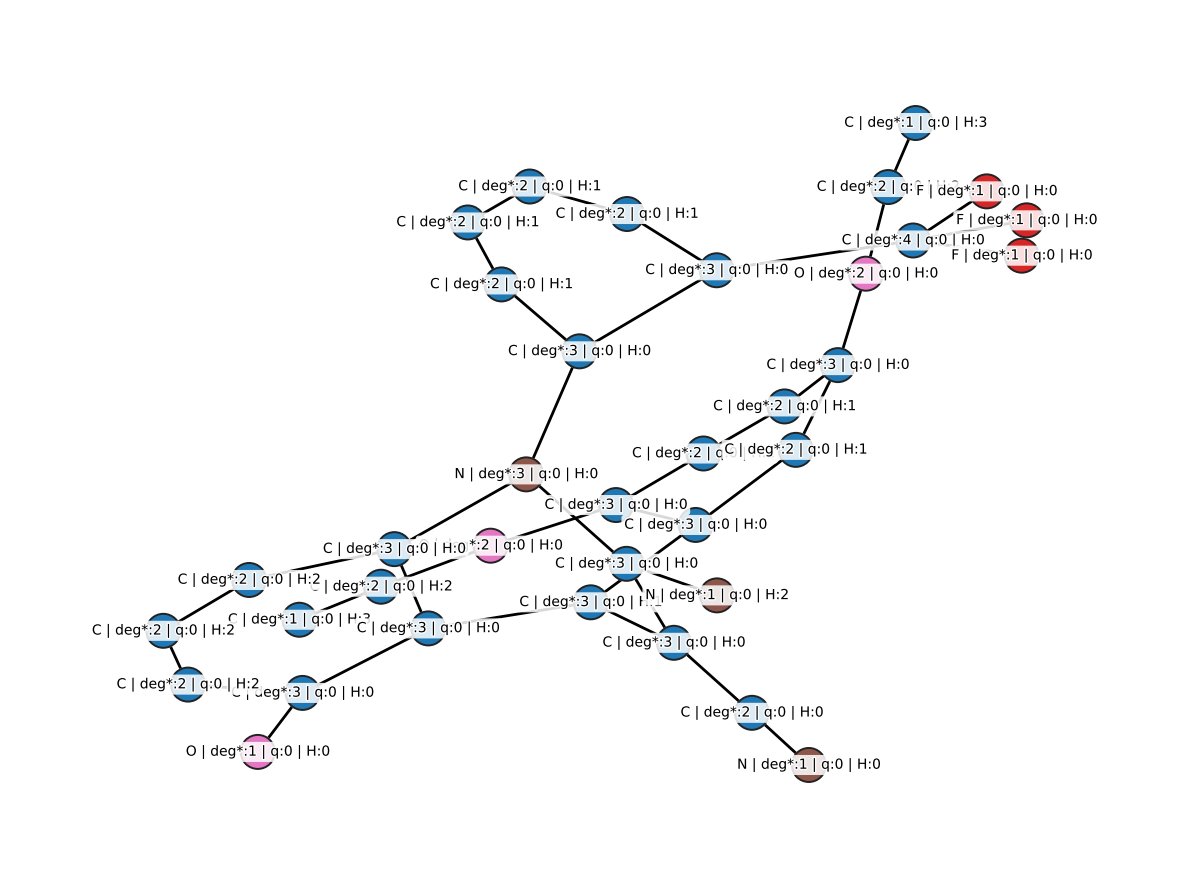

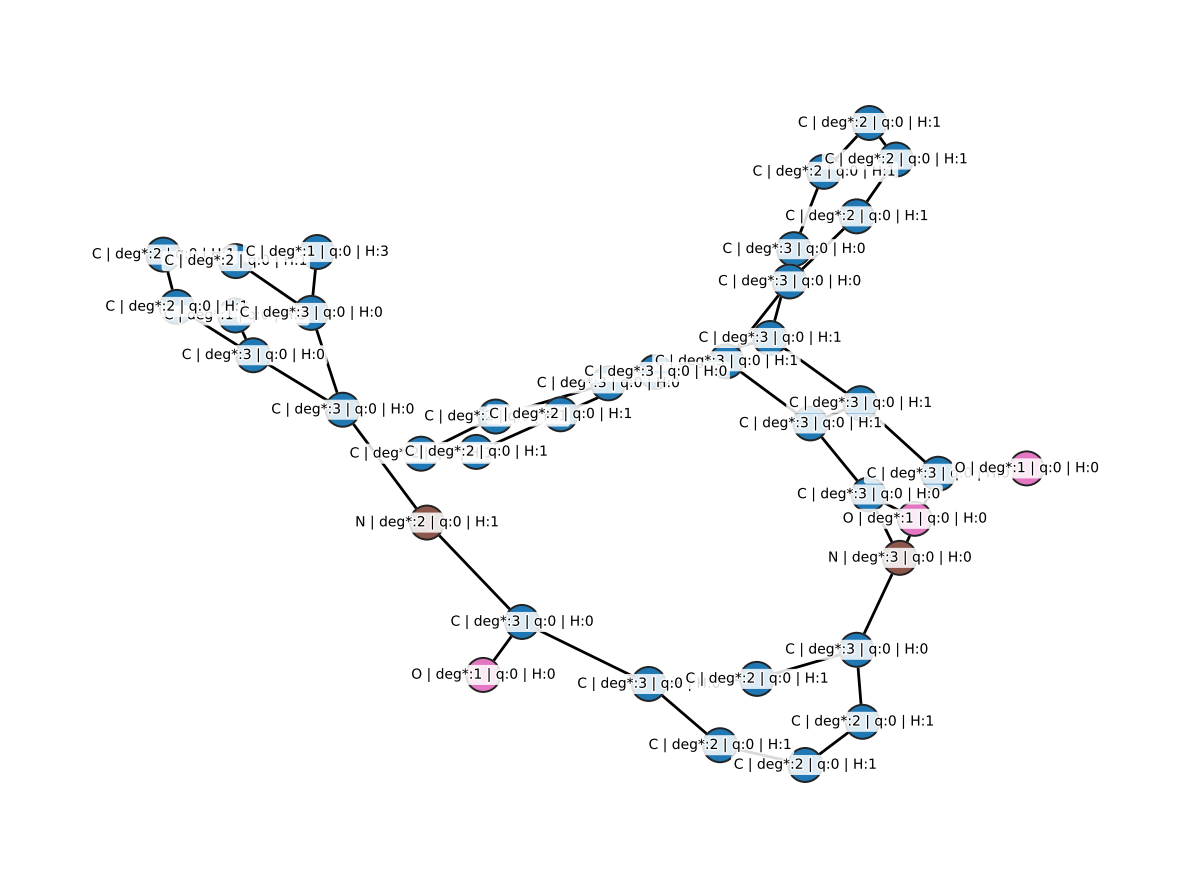

In [6]:
import random

from src.utils.chem import draw_mol
from pathlib import Path
from matplotlib import pyplot as plt
from src.utils.visualisations import draw_nx_with_atom_colorings
from src.utils.utils import DataTransformer
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.datasets.qm9_smiles_generation import QM9Smiles

qm9 = QM9Smiles(split="train")
zinc = ZincSmiles(split="train")

sorted_qm9 = sorted(qm9, key=lambda x: len(x.x))
sorted_zinc = sorted(zinc, key=lambda x: len(x.x))

samples = {
    "small_1": (sorted_qm9[100], "QM9Smiles"),
    "small_2": (sorted_qm9[10000], "QM9Smiles"),
    "small_3": (sorted_qm9[-1], "QM9Smiles"),
    "large_1": (sorted_zinc[1000], "ZincSmiles"),
    "large_2": (zinc[10], "ZincSmiles"),
    "large_3": (sorted_zinc[-100000], "ZincSmiles"),
    "large_4": (sorted_zinc[-5000], "ZincSmiles"),
    "large_5": (sorted_zinc[-1000], "ZincSmiles"),
    "large_6": (ZincSmiles(split="test")[10], "ZincSmiles"),
    "large_7": (sorted_zinc[-1], "ZincSmiles")
}
examples = []
out = Path() / "examples"
out.mkdir(exist_ok=True, parents=True)
for i, (name, (data, dataset)) in enumerate(samples.items()):
    res = {}
    nx_g = DataTransformer.pyg_to_nx(data)
    print(f"{name}: {nx_g.number_of_nodes()}")
    draw_nx_with_atom_colorings(nx_g, dataset=dataset)
    plt.savefig(out / f"{name}_nx.png")
    mol, _ = DataTransformer.nx_to_mol_v2(nx_g, dataset="qm9" if dataset == "QM9Smiles" else "zinc")
    draw_mol(mol=mol, save_path=str(out / f"{name}_mol.png"), fmt="png")
    node_tuples = [tuple(i) for i in data.x.int().tolist()]
    node_tuples = [(a, b+1, c, d) for a, b, c, d in node_tuples]
    edge_idxs = [tuple(e) for e in data.edge_index.t().cpu().int().tolist()]
    edge_tuples = [(node_tuples[u], node_tuples[v]) for u, v in edge_idxs]
    the_input = {
        "nodes_multiset": [tuple(e) for e in random.sample(node_tuples, k=len(node_tuples))],
        "edges_multiset": edge_tuples,
    }
    expected_output = {
        "ordered_nodes": node_tuples,
        "associated_edge_idxs": edge_idxs,
    }
    examples.append({
        name: {
            "input": the_input,
            "expected_output": expected_output,
        },
    })

with open(out / "examples.json", "w") as f:
    import json
    json.dump(examples, f, indent=None, separators=(",", ":"))
